In [1]:
import pandas as pd
import numpy as np
import glob
home_dir = '/home/zehai/2018NBA_Hackathon_Files/Business Analytics/'
file_list = glob.glob(home_dir+'*.csv')
print ([x.split('/')[-1].strip('.csv') for x in file_list])


import matplotlib.pyplot as plt
import seaborn as sns

['game_data', 'team_market', 'training_set', 'team_market_value', 'test_set', 'player_data']


In [2]:
test_df = pd.read_csv(home_dir+'test_set.csv',parse_dates=["Game_Date"])
player_data = pd.read_csv(home_dir+'player_data.csv',parse_dates=["Game_Date"])
game_data = pd.read_csv(home_dir+'game_data.csv',parse_dates=["Game_Date"])
train_df = pd.read_csv(home_dir+'training_set.csv',parse_dates=["Game_Date"])

In [3]:
train_df.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Country,Rounded Viewers
0,2016-17,21600001,2016-10-25,NYK,CLE,C113,18
1,2016-17,21600001,2016-10-25,NYK,CLE,C193,1
2,2016-17,21600001,2016-10-25,NYK,CLE,C126,4
3,2016-17,21600001,2016-10-25,NYK,CLE,C163,11
4,2016-17,21600001,2016-10-25,NYK,CLE,C73,3


In [4]:
# Sum viewers of all countries based on Game_ID
train_df = train_df.groupby(['Season','Game_ID','Game_Date','Away_Team','Home_Team'])['Rounded Viewers'].sum().reset_index()
train_df.rename(index=str, columns={"Rounded Viewers":"Total_Viewers"},inplace = True)
train_df.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers
0,2016-17,21600001,2016-10-25,NYK,CLE,57691
1,2016-17,21600002,2016-10-25,UTA,POR,40740
2,2016-17,21600003,2016-10-25,SAS,GSW,60428
3,2016-17,21600004,2016-10-26,MIA,ORL,22756
4,2016-17,21600005,2016-10-26,DAL,IND,33922


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 6 columns):
Season           460 non-null object
Game_ID          460 non-null int64
Game_Date        460 non-null datetime64[ns]
Away_Team        460 non-null object
Home_Team        460 non-null object
Total_Viewers    0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 21.6+ KB


In [6]:
test_df.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers
0,2016-17,21600010,2016-10-26,DEN,NOP,NaN
1,2016-17,21600023,2016-10-28,HOU,DAL,NaN
2,2016-17,21600027,2016-10-29,BOS,CHA,NaN
3,2016-17,21600026,2016-10-29,ATL,PHI,NaN
4,2016-17,21600048,2016-11-01,LAL,IND,NaN


 #1. Create new features: Weekday, Month, VIP
 #2. Label encode categorical variables
 #3. Drop unused columns

In [7]:
full_df = [train_df, test_df]

In [8]:
# 1. Create new features: Weekday, Month, VIP
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays= cal.holidays()

for df in full_df:
    df['day'] = df.Game_Date.dt.day
    df['weekday'] = df.Game_Date.dt.weekday
    df['month'] = df.Game_Date.dt.month
#     df['holiday']= df.Game_Date.isin(holidays)
   
    
# number ASG player in the Game
player_data['ASG_status'] = (player_data['ASG_Team']!= 'None')
ASG_per_Game = player_data.groupby('Game_ID')['ASG_status'].sum().to_frame().reset_index()

In [9]:
train_df = train_df.merge(ASG_per_Game, on='Game_ID')
test_df = test_df.merge(ASG_per_Game, on='Game_ID')

In [10]:
# Add team market size
def loss_rate(row):
    if (row.Losses_Entering_Gm ==0) \
    or (row.Wins_Entering_Gm+row.Losses_Entering_Gm)<5:
        return 0
    else:
        return row.Losses_Entering_Gm/(row.Wins_Entering_Gm+row.Losses_Entering_Gm)


game_data['loss_rate'] = game_data.apply(loss_rate, axis = 1)
tmp = game_data.groupby('Game_ID')['loss_rate'].sum()
train_df = pd.merge(train_df,tmp.to_frame().reset_index(),on='Game_ID')
test_df = pd.merge(test_df,tmp.to_frame().reset_index(),on='Game_ID')

In [11]:
# Add market size as feature
team_market_value = pd.read_csv('/home/zehai/2018NBA_Hackathon_Files/Business Analytics/team_market_value.csv')
team_market_value['Market'] = team_market_value['Market']//100
market_value_dict = dict(zip(team_market_value['Team'],team_market_value['Market']))
def market_cal(row):
    return (market_value_dict[row.Away_Team]+market_value_dict[row.Home_Team])

train_df['Game Market'] = train_df.apply(market_cal,axis=1)
test_df['Game Market'] = test_df.apply(market_cal,axis=1)


In [12]:
# Add game score features:
# score difference the last two minutes
def diff_group(X):
    return (X.max()-X.min())
l = game_data.groupby('Game_ID')['L2M_Score'].apply(diff_group).sort_values(ascending=False).to_frame().reset_index()
train_df = train_df.merge(l, on='Game_ID')
test_df = test_df.merge(l, on='Game_ID')

# Final score
game_lead_level = game_data.groupby('Game_ID')['Ties'].sum().sort_values(ascending=False).to_frame().reset_index()
train_df = train_df.merge(game_lead_level, on='Game_ID')
test_df = test_df.merge(game_lead_level, on='Game_ID')

In [13]:
test_df.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers,day,weekday,month,ASG_status,loss_rate,Game Market,L2M_Score,Ties
0,2016-17,21600010,2016-10-26,DEN,NOP,NaN,26,2,10,1.0,0.0,21,NaN,0.0
1,2016-17,21600023,2016-10-28,HOU,DAL,NaN,28,4,10,1.0,0.0,41,NaN,0.0
2,2016-17,21600027,2016-10-29,BOS,CHA,NaN,29,5,10,2.0,0.0,35,NaN,0.0
3,2016-17,21600026,2016-10-29,ATL,PHI,NaN,29,5,10,1.0,0.0,22,NaN,0.0
4,2016-17,21600048,2016-11-01,LAL,IND,NaN,1,1,11,1.0,0.0,44,NaN,0.0


### Label_encodeing

In [14]:
# Target and ID variables #
train_y = train_df["Total_Viewers"].values
test_id = test_df["Game_ID"].values

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split

# Label encode the categorical variables #
cat_vars = ["Season","Away_Team","Home_Team"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

In [16]:
cols_to_drop = ["Game_ID","Game_Date","Total_Viewers"]
train_X = train_df.drop(cols_to_drop, axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [17]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 459
Data columns (total 11 columns):
Season         460 non-null int64
Away_Team      460 non-null int64
Home_Team      460 non-null int64
day            460 non-null int64
weekday        460 non-null int64
month          460 non-null int64
ASG_status     460 non-null float64
loss_rate      460 non-null float64
Game Market    460 non-null int64
L2M_Score      0 non-null float64
Ties           460 non-null float64
dtypes: float64(4), int64(7)
memory usage: 43.1 KB


In [18]:
import lightgbm as lgb

In [19]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "mape",
        "num_leaves" : 10,
        "max_depth":12,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.75,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=400, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [20]:
# Splitting the data for model training#
# dev_X = train_X.iloc[:-200,:]
# val_X = train_X.iloc[-200:,:]
# dev_y = train_y[:-200]
# val_y = train_y[-200:]
# print(dev_X.shape, val_X.shape, test_X.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
        train_X, train_y, test_size=0.15, random_state=2018)

In [21]:
# Training the model #
pred_test, model, evals_result = run_lgb(X_train, y_train, X_valid, y_valid, test_X)

# Making a submission file #
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["Total_Viewers"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

Training until validation scores don't improve for 400 rounds.
[20]	valid_0's mape: 0.603505
[40]	valid_0's mape: 0.572101
[60]	valid_0's mape: 0.544082
[80]	valid_0's mape: 0.521275
[100]	valid_0's mape: 0.500573
[120]	valid_0's mape: 0.485591
[140]	valid_0's mape: 0.47091
[160]	valid_0's mape: 0.457487
[180]	valid_0's mape: 0.446006
[200]	valid_0's mape: 0.437788
[220]	valid_0's mape: 0.428712
[240]	valid_0's mape: 0.420442
[260]	valid_0's mape: 0.414013
[280]	valid_0's mape: 0.406889
[300]	valid_0's mape: 0.401041
[320]	valid_0's mape: 0.395241
[340]	valid_0's mape: 0.390398
[360]	valid_0's mape: 0.385487
[380]	valid_0's mape: 0.380555
[400]	valid_0's mape: 0.374962
[420]	valid_0's mape: 0.37037
[440]	valid_0's mape: 0.36721
[460]	valid_0's mape: 0.36378
[480]	valid_0's mape: 0.359718
[500]	valid_0's mape: 0.356143
[520]	valid_0's mape: 0.352771
[540]	valid_0's mape: 0.349906
[560]	valid_0's mape: 0.34746
[580]	valid_0's mape: 0.345259
[600]	valid_0's mape: 0.342988
[620]	valid_0's 

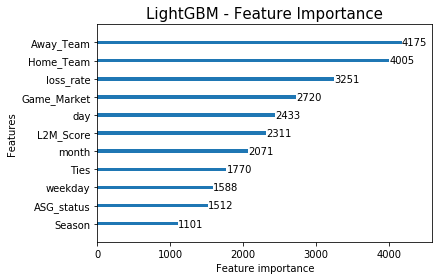

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(6,4))
lgb.plot_importance(model, max_num_features=50, height=0.2, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(
        train_df, train_df['Total_Viewers'], test_size=0.10, random_state=2018)

In [24]:
X_provide = X_valid.drop(cols_to_drop, axis=1)

In [25]:
y_valid.head()

386     10062
1645     8191
461     14475
1941     2771
200     34859
Name: Total_Viewers, dtype: int64

In [26]:
X_valid.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers,day,weekday,month,ASG_status,loss_rate,Game Market,L2M_Score,Ties
386,0,21600471,2016-12-26,22,25,10062,26,0,12,1.0,1.325287,24,2.0,7.0
1645,1,21700789,2018-02-04,3,23,8191,4,6,2,1.0,1.229005,22,7.0,7.0
461,0,21600561,2017-01-08,15,12,14475,8,6,1,1.0,1.069501,38,16.0,3.0
1941,1,21701159,2018-04-03,21,19,2771,3,1,4,1.0,1.359877,48,21.0,12.0
200,0,21600245,2016-11-27,5,22,34859,27,6,11,3.0,0.892857,24,11.0,2.0


In [27]:
pred_test_y = model.predict(X_provide, num_iteration=model.best_iteration)

In [28]:
X_valid['Predictions']= pred_test_y

/home/zehai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
len(pred_test)

460

In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 459
Data columns (total 14 columns):
Season           460 non-null int64
Game_ID          460 non-null int64
Game_Date        460 non-null datetime64[ns]
Away_Team        460 non-null int64
Home_Team        460 non-null int64
Total_Viewers    0 non-null float64
day              460 non-null int64
weekday          460 non-null int64
month            460 non-null int64
ASG_status       460 non-null float64
loss_rate        460 non-null float64
Game Market      460 non-null int64
L2M_Score        0 non-null float64
Ties             460 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(8)
memory usage: 53.9 KB


In [32]:
X_valid

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers,day,weekday,month,ASG_status,loss_rate,Game Market,L2M_Score,Ties,Predictions
386,0,21600471,2016-12-26,22,25,10062,26,0,12,1.0,1.325287,24,2.0,7.0,12786.858183
1645,1,21700789,2018-02-04,3,23,8191,4,6,2,1.0,1.229005,22,7.0,7.0,7117.059352
461,0,21600561,2017-01-08,15,12,14475,8,6,1,1.0,1.069501,38,16.0,3.0,13075.042047
1941,1,21701159,2018-04-03,21,19,2771,3,1,4,1.0,1.359877,48,21.0,12.0,5992.809721
200,0,21600245,2016-11-27,5,22,34859,27,6,11,3.0,0.892857,24,11.0,2.0,33328.647007
1938,1,21701156,2018-04-03,27,5,36222,3,1,4,4.0,0.665926,27,14.0,5.0,30986.757513
1919,1,21701129,2018-03-30,4,21,7276,30,4,3,0.0,1.382703,38,11.0,4.0,4505.065056
528,0,21600646,2017-01-20,9,10,53185,20,4,1,5.0,0.409524,53,18.0,2.0,45355.005175
1387,1,21700456,2017-12-20,15,2,24533,20,2,12,3.0,0.712121,42,6.0,1.0,23987.088068
568,0,21600695,2017-01-27,1,5,22613,27,4,1,3.0,1.118182,36,12.0,3.0,21633.653516


In [33]:
X_valid['error'] = abs((X_valid['Predictions']-X_valid['Total_Viewers'])/X_valid['Total_Viewers'])

/home/zehai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
X_valid.sort_values(by ='error', ascending=False)

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers,day,weekday,month,ASG_status,loss_rate,Game Market,L2M_Score,Ties,Predictions,error
1092,1,21700096,2017-10-30,3,14,6064,30,0,10,1.0,0.666667,20,4.0,12.0,14829.132014,1.445437
1126,1,21700142,2017-11-05,11,19,13866,5,6,11,2.0,0.944444,47,0.0,7.0,30492.869759,1.199111
797,0,21600981,2017-03-11,0,14,4349,11,5,3,2.0,0.892308,21,17.0,1.0,9459.907884,1.175192
1941,1,21701159,2018-04-03,21,19,2771,3,1,4,1.0,1.359877,48,21.0,12.0,5992.809721,1.162688
1074,1,21700073,2017-10-27,1,19,13735,27,4,10,1.0,0.400000,59,19.0,4.0,28676.420758,1.087836
1642,1,21700786,2018-02-04,0,19,9779,4,6,2,1.0,1.277576,47,3.0,14.0,19628.572130,1.007217
1163,1,21700183,2017-11-11,4,26,7517,11,5,11,1.0,1.216667,41,34.0,0.0,14814.811428,0.970841
993,0,21601208,2017-04-10,29,8,5372,10,0,4,1.0,0.937500,24,4.0,4.0,10440.978625,0.943592
1341,1,21700403,2017-12-12,23,25,4387,12,1,12,0.0,1.370879,25,6.0,11.0,8511.287520,0.940116
785,0,21600969,2017-03-10,27,0,7662,10,4,3,3.0,0.859375,25,6.0,17.0,14650.498155,0.912098


In [35]:
X_valid.sort_values(by ='error', ascending=False)["Game_ID"][:10].tolist()

[21700096,
 21700142,
 21600981,
 21701159,
 21700073,
 21700786,
 21700183,
 21601208,
 21700403,
 21600969]

In [36]:
X_valid.sort_values(by ='error', ascending=True)["Game_ID"][:10].tolist()

[21600345,
 21701036,
 21700303,
 21700362,
 21700467,
 21601159,
 21600415,
 21600045,
 21700121,
 21700792]

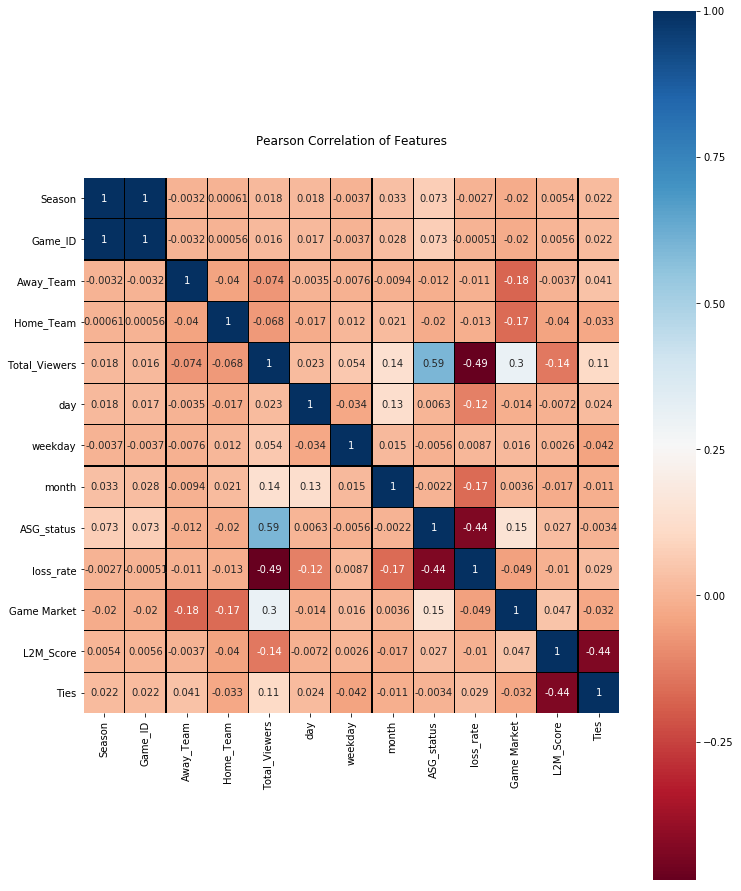

In [37]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,16))
plt.title('Pearson Correlation of Features', y=1.05, size=12)
sns.heatmap(train_df.drop(['Game_Date'],axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='Black', annot=True)

In [39]:
len(pred_test)

460

In [40]:
test_df = pd.read_csv(home_dir+'test_set.csv',parse_dates=["Game_Date"])

In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 6 columns):
Season           460 non-null object
Game_ID          460 non-null int64
Game_Date        460 non-null datetime64[ns]
Away_Team        460 non-null object
Home_Team        460 non-null object
Total_Viewers    0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 21.6+ KB


In [50]:
test_df['Total_Viewers'] = [int(round(i)) for i in pred_test]

In [51]:
test_df.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers
0,2016-17,21600010,2016-10-26,DEN,NOP,19790
1,2016-17,21600023,2016-10-28,HOU,DAL,29265
2,2016-17,21600027,2016-10-29,BOS,CHA,27564
3,2016-17,21600026,2016-10-29,ATL,PHI,28199
4,2016-17,21600048,2016-11-01,LAL,IND,29372


In [52]:
test_df.to_csv("test_set_Niubility.csv")